In [55]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import shap
import socket
import matplotlib.pyplot as plt
from tqdm import tqdm

In [56]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [57]:
import seaborn as sns
import os
import gc
import math
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import ClusterCentroids
from imblearn.combine import SMOTEENN

In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

In [59]:
# import tensorflow as tf
# from tensorflow.keras import layers, models

In [60]:
df = pd.read_csv("../data/raw/CIC_IoMT_2024_WiFi_MQTT_train.csv")

In [61]:
label_mapping = {
    'Benign': ['Benign_train'],
    
    'Spoofing': ['ARP_Spoofing_train'],

    'Reconnaissance': [
        'Recon-OS_Scan_train',
        'Recon-Ping_Sweep_train',
        'Recon-VulScan_train',
        'Recon-Port_Scan_train'
    ],
    
    'MQTT': [
        'MQTT-Malformed_Data_train',
        'MQTT-DoS-Connect_Flood_train',
        'MQTT-DDoS-Publish_Flood_train',
        'MQTT-DoS-Publish_Flood_train',
        'MQTT-DDoS-Connect_Flood_train'
    ],

    'DoS': [
        'TCP_IP-DoS-TCP1_train', 'TCP_IP-DoS-TCP2_train', 'TCP_IP-DoS-TCP3_train', 'TCP_IP-DoS-TCP4_train',
        'TCP_IP-DoS-UDP1_train', 'TCP_IP-DoS-UDP2_train', 'TCP_IP-DoS-UDP3_train', 'TCP_IP-DoS-UDP4_train',
        'TCP_IP-DoS-ICMP1_train', 'TCP_IP-DoS-ICMP2_train', 'TCP_IP-DoS-ICMP3_train', 'TCP_IP-DoS-ICMP4_train',
        'TCP_IP-DoS-SYN1_train', 'TCP_IP-DoS-SYN2_train', 'TCP_IP-DoS-SYN3_train', 'TCP_IP-DoS-SYN4_train'
    ],

    'DDoS': [
        'TCP_IP-DDoS-TCP1_train', 'TCP_IP-DDoS-TCP2_train', 'TCP_IP-DDoS-TCP3_train', 'TCP_IP-DDoS-TCP4_train',
        'TCP_IP-DDoS-UDP1_train', 'TCP_IP-DDoS-UDP2_train', 'TCP_IP-DDoS-UDP3_train', 'TCP_IP-DDoS-UDP4_train',
        'TCP_IP-DDoS-UDP5_train', 'TCP_IP-DDoS-UDP6_train', 'TCP_IP-DDoS-UDP7_train', 'TCP_IP-DDoS-UDP8_train',
        'TCP_IP-DDoS-ICMP1_train', 'TCP_IP-DDoS-ICMP2_train', 'TCP_IP-DDoS-ICMP3_train', 'TCP_IP-DDoS-ICMP4_train',
        'TCP_IP-DDoS-ICMP5_train', 'TCP_IP-DDoS-ICMP6_train', 'TCP_IP-DDoS-ICMP7_train', 'TCP_IP-DDoS-ICMP8_train',
        'TCP_IP-DDoS-SYN1_train', 'TCP_IP-DDoS-SYN2_train', 'TCP_IP-DDoS-SYN3_train', 'TCP_IP-DDoS-SYN4_train'
    ]
}

In [62]:
def map_category(label):
    for parent, sub_labels in label_mapping.items():
        if label in sub_labels:
            return parent
    return 'Unknown'
df['SuperClass'] = df['label'].apply(map_category)

In [63]:
grouped = df.groupby(['SuperClass', 'label']).size().reset_index(name='Records')
total = len(df)
grouped['Percentage'] = (grouped['Records'] / total) * 100

summary = grouped.groupby('SuperClass')['Records'].sum().reset_index()
summary['Percentage'] = (summary['Records'] / total) * 100

print("Hierarchical Breakdown:")
display(grouped.sort_values(['SuperClass', 'Records'], ascending=[True, False]).head(20))

print("Category Summary:")
display(summary)

Hierarchical Breakdown:


,SuperClass,label,Records,Percentage
0,Benign,Benign_train,192732,2.691475
18,DDoS,TCP_IP-DDoS-UDP2_train,207295,2.894846
19,DDoS,TCP_IP-DDoS-UDP3_train,206604,2.885196
20,DDoS,TCP_IP-DDoS-UDP4_train,206343,2.881551
17,DDoS,TCP_IP-DDoS-UDP1_train,206170,2.879135
21,DDoS,TCP_IP-DDoS-UDP5_train,205507,2.869876
24,DDoS,TCP_IP-DDoS-UDP8_train,204105,2.850298
15,DDoS,TCP_IP-DDoS-TCP3_train,204075,2.849879
10,DDoS,TCP_IP-DDoS-SYN2_train,203669,2.844209
13,DDoS,TCP_IP-DDoS-TCP1_train,202311,2.825245


Category Summary:


,SuperClass,Records,Percentage
0,Benign,192732,2.691475
1,DDoS,4779859,66.750060
2,DoS,1805529,25.213959
3,MQTT,262938,3.671892
4,Reconnaissance,103726,1.448519
5,Spoofing,16047,0.224094


In [64]:
ID_COLS = ['label', 'SuperClass']

In [65]:
DROP_COLS = ['Boot_Time_with_date', 'RTime', 'SrcAddr', 'DstAddr', 'SrcMac', 'DstMac', 'IMEI']

In [66]:
RATE_COLS = ['Rate', 'Srate', 'Drate'] 

In [67]:
TARGET_COUNTS = {
    'DDoS': 500_000,
    'DoS':  500_000,
    'Benign': 300_000,
    'MQTT': 300_000,
    'Reconnaissance': 200_000,
    'Spoofing': 200_000
}

In [68]:
cols_to_drop = [c for c in DROP_COLS if c in df.columns]
if cols_to_drop:
    print("Dropping ID/time columns:", cols_to_drop)
    df = df.drop(columns=cols_to_drop)

In [69]:
df.head()

,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,...,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label,SuperClass
0,683.50,17.00,64.0,553148.440,553148.440,0,0.0,0.0,0.0,0.00,...,50.00,101635944.0,9.5,10.00,0.000,0.000000,0.00,141.5,TCP_IP-DDoS-UDP2_train,DDoS
1,1745.92,16.12,64.0,29919.545,29919.545,0,0.0,0.0,0.0,0.04,...,52.28,84696616.0,9.5,10.05,2.152,11.785338,0.23,141.5,TCP_IP-DDoS-UDP2_train,DDoS
2,2830.36,15.79,64.0,27075.605,27075.605,0,0.0,0.0,0.0,0.06,...,53.25,84696616.0,9.5,10.35,10.555,113.675460,0.53,141.5,TCP_IP-DDoS-UDP2_train,DDoS
3,4087.50,16.89,64.0,19660.156,19660.156,0,0.0,0.0,0.0,0.00,...,50.16,84696616.0,9.5,10.03,1.236,4.490081,0.18,141.5,TCP_IP-DDoS-UDP2_train,DDoS
4,3916.00,17.00,64.0,270322.780,270322.780,0,0.0,0.0,0.0,0.00,...,50.00,84696616.0,9.5,10.00,0.000,0.000000,0.00,141.5,TCP_IP-DDoS-UDP2_train,DDoS


In [70]:
df['SuperClass'].value_counts()

SuperClass
DDoS              4779859
DoS               1805529
MQTT               262938
Benign             192732
Reconnaissance     103726
Spoofing            16047
Name: count, dtype: int64

In [71]:
feature_cols = [c for c in df.columns if c not in ID_COLS]
print(f"Feature count: {len(feature_cols)}")

X_raw = df[feature_cols].copy()
y_raw = df['SuperClass'].copy()

Feature count: 45


In [72]:
non_numeric = [c for c in X_raw.columns if not np.issubdtype(X_raw[c].dtype, np.number)]
if non_numeric:
    print("Non-numeric columns detected - converting to numeric (if possible) or dropping:", non_numeric)
    for c in non_numeric:
        X_raw[c] = pd.to_numeric(X_raw[c], errors='coerce')
    non_numeric_after = [c for c in X_raw.columns if not np.issubdtype(X_raw[c].dtype, np.number)]
    if non_numeric_after:
        print("Dropping columns still non-numeric:", non_numeric_after)
        X_raw = X_raw.drop(columns=non_numeric_after)

In [73]:
rate_cols_present = [c for c in RATE_COLS if c in X_raw.columns]
if rate_cols_present:
    print("Applying MinMax normalization to rate cols:", rate_cols_present)
    mms = MinMaxScaler()
    X_raw[rate_cols_present] = mms.fit_transform(X_raw[rate_cols_present])

Applying MinMax normalization to rate cols: ['Rate', 'Srate', 'Drate']


In [74]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)
del X_raw
gc.collect()

0

In [75]:
X_scaled.shape

(7160831, 45)

In [76]:
y_raw.shape

(7160831,)

In [77]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_raw, test_size=0.2, stratify=y_raw, random_state=42
)

In [78]:
import numpy as np
import pandas as pd

def hybrid_balance_safe(df, label_col='SuperClass', target_n=60000, random_state=42):
    np.random.seed(random_state)
    balanced_parts = []
    num_cols = [c for c in df.columns if c not in ['label', label_col]]

    for cls, group in df.groupby(label_col):
        n_avail = len(group)
        print(f"Class {cls} -> available: {n_avail}")

        if n_avail > target_n:
            # Downsample
            sampled = group.sample(n=target_n, random_state=random_state)

        elif n_avail == target_n:
            sampled = group

        elif n_avail >= 5:
            # Gaussian noise augmentation for numeric features
            X = group[num_cols].copy()
            n_to_gen = target_n - n_avail

            # Compute per-column stds and add jitter
            stds = X.std(axis=0, ddof=0).replace(0, 1e-6)
            synth_samples = X.sample(n=n_to_gen, replace=True, random_state=random_state)
            noise = np.random.normal(0, 0.01, synth_samples.shape) * stds.values
            synth_samples = synth_samples + noise

            synth_df = synth_samples.copy()
            synth_df[label_col] = cls
            synth_df['label'] = group['label'].sample(
                n=n_to_gen, replace=True, random_state=random_state
            ).values

            sampled = pd.concat([group, synth_df], ignore_index=True)

        else:
            # Tiny class — replicate with replacement
            sampled = group.sample(n=target_n, replace=True, random_state=random_state)

        balanced_parts.append(sampled)

    balanced_df = (
        pd.concat(balanced_parts)
        .sample(frac=1, random_state=random_state)
        .reset_index(drop=True)
    )

    print("\n✅ Done! New distribution:")
    print(balanced_df[label_col].value_counts())
    return balanced_df

In [79]:
subset_df = hybrid_balance_safe(df, label_col='SuperClass', target_n=16047)

Class Benign -> available: 192732
Class DDoS -> available: 4779859
Class DoS -> available: 1805529
Class MQTT -> available: 262938
Class Reconnaissance -> available: 103726
Class Spoofing -> available: 16047

✅ Done! New distribution:
SuperClass
Spoofing          16047
Benign            16047
DDoS              16047
Reconnaissance    16047
DoS               16047
MQTT              16047
Name: count, dtype: int64


In [80]:
subset_df.duplicated().sum()

np.int64(4180)

In [81]:
X = subset_df.drop(columns=['label','SuperClass'], errors='ignore')
y = subset_df['SuperClass']
le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, stratify=y_enc, random_state=42)

rf = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

                precision    recall  f1-score   support

        Benign       0.97      0.96      0.97      3209
          DDoS       1.00      1.00      1.00      3209
           DoS       1.00      1.00      1.00      3210
          MQTT       1.00      0.99      1.00      3210
Reconnaissance       0.99      0.97      0.98      3210
      Spoofing       0.94      0.98      0.96      3209

      accuracy                           0.98     19257
     macro avg       0.98      0.98      0.98     19257
  weighted avg       0.98      0.98      0.98     19257



In [82]:
# Combine features and labels
df_combined = pd.concat([X, y], axis=1)

df_combined = df_combined.drop_duplicates()

X_subset = df_combined.drop("SuperClass", axis=1)
y_subset = df_combined["SuperClass"]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_subset, y_subset, stratify=y_subset, test_size=0.2, random_state=42
)


In [83]:
print(X_train.duplicated().sum(), X_test.duplicated().sum())

0 0


In [84]:
X_train.shape

(73658, 45)

In [85]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
num_classes = len(le.classes_)

In [86]:
X_train_scaledd = scaler.fit_transform(X_train)
X_test_scaledd = scaler.transform(X_test)

In [87]:
X_train_scaled = X_train_scaledd[..., np.newaxis]
X_test_scaled = X_test_scaledd[..., np.newaxis]

In [88]:
rf = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

                precision    recall  f1-score   support

        Benign       0.97      0.96      0.96      3210
          DDoS       1.00      1.00      1.00      2773
           DoS       1.00      1.00      1.00      2962
          MQTT       1.00      0.99      0.99      3209
Reconnaissance       0.99      0.97      0.98      3059
      Spoofing       0.93      0.98      0.95      3202

      accuracy                           0.98     18415
     macro avg       0.98      0.98      0.98     18415
  weighted avg       0.98      0.98      0.98     18415



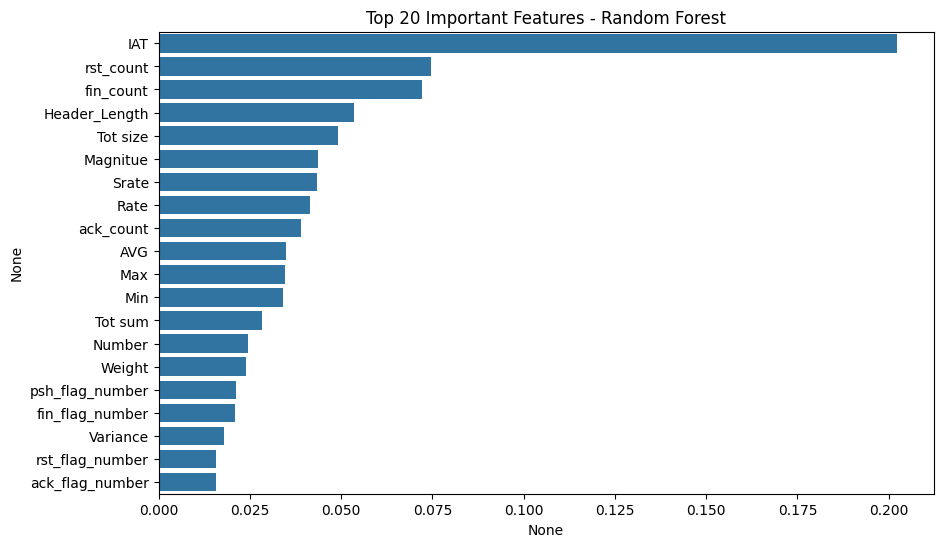

In [89]:
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp[:20], y=feat_imp.index[:20])
plt.title("Top 20 Important Features - Random Forest")
plt.show()

In [90]:
import xgboost as xgb
xgb_clf = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42,
    n_jobs=4
)


In [91]:
xgb_clf.fit(X_train_scaledd, y_train_enc)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [92]:
y_pred = xgb_clf.predict(X_test_scaledd)

In [93]:
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))

                precision    recall  f1-score   support

        Benign       0.97      0.96      0.97      3210
          DDoS       1.00      1.00      1.00      2773
           DoS       1.00      1.00      1.00      2962
          MQTT       1.00      0.99      1.00      3209
Reconnaissance       1.00      0.97      0.98      3059
      Spoofing       0.93      0.98      0.96      3202

      accuracy                           0.98     18415
     macro avg       0.98      0.98      0.98     18415
  weighted avg       0.98      0.98      0.98     18415



In [94]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [95]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_enc, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_enc, dtype=torch.long)

In [96]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [97]:
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

In [98]:
class OneDCNN(nn.Module):
    def __init__(self, input_len, num_classes):
        super(OneDCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        self.global_pool = nn.AdaptiveMaxPool1d(1)   # replaces GlobalMaxPooling1D
        self.fc1 = nn.Linear(128, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # x shape: (batch, seq_len, channels) → need to permute for Conv1d
        x = x.permute(0, 2, 1)
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.conv2(x))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x 

In [99]:
input_len = X_train_scaled.shape[1]
model = OneDCNN(input_len, num_classes).to(device)
print(model)

OneDCNN(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (global_pool): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)


In [101]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=1e-3)

In [102]:
history = {
    "epoch": [],
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
    "precision": [],
    "recall": [],
    "f1": []
}

In [105]:
num_epochs = 300

In [106]:
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    train_loss = running_loss / total
    train_acc = correct / total

    # --- Validation ---
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    all_preds, all_labels = [], []  # <-- added

    with torch.no_grad():
        for X_val, y_val in test_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)

            # record loss
            loss = criterion(outputs, y_val)
            val_loss += loss.item() * X_val.size(0)

            _, predicted = torch.max(outputs, 1)
            val_total += y_val.size(0)
            val_correct += (predicted == y_val).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_val.cpu().numpy())

    val_loss /= val_total
    val_acc = val_correct / val_total

    # extra metrics
    precision = precision_score(all_labels, all_preds, average="macro")
    recall = recall_score(all_labels, all_preds, average="macro")
    f1 = f1_score(all_labels, all_preds, average="macro")

    # Store metrics
    history["epoch"].append(epoch + 1)
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["precision"].append(precision)
    history["recall"].append(recall)
    history["f1"].append(f1)

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} | "
          f"F1: {f1:.4f}")


Epoch [1/300] - Train Loss: 0.3416, Train Acc: 0.8328 | Val Loss: 0.3413, Val Acc: 0.8352 | F1: 0.8243
Epoch [2/300] - Train Loss: 0.3400, Train Acc: 0.8338 | Val Loss: 0.3437, Val Acc: 0.8260 | F1: 0.8184
Epoch [3/300] - Train Loss: 0.3404, Train Acc: 0.8354 | Val Loss: 0.3379, Val Acc: 0.8338 | F1: 0.8279
Epoch [4/300] - Train Loss: 0.3383, Train Acc: 0.8358 | Val Loss: 0.3466, Val Acc: 0.8293 | F1: 0.8247
Epoch [5/300] - Train Loss: 0.3360, Train Acc: 0.8373 | Val Loss: 0.3386, Val Acc: 0.8342 | F1: 0.8253
Epoch [6/300] - Train Loss: 0.3387, Train Acc: 0.8373 | Val Loss: 0.3349, Val Acc: 0.8377 | F1: 0.8318
Epoch [7/300] - Train Loss: 0.3357, Train Acc: 0.8369 | Val Loss: 0.3372, Val Acc: 0.8330 | F1: 0.8282
Epoch [8/300] - Train Loss: 0.3334, Train Acc: 0.8372 | Val Loss: 0.3357, Val Acc: 0.8319 | F1: 0.8271
Epoch [9/300] - Train Loss: 0.3329, Train Acc: 0.8375 | Val Loss: 0.3378, Val Acc: 0.8336 | F1: 0.8227
Epoch [10/300] - Train Loss: 0.3337, Train Acc: 0.8379 | Val Loss: 0.3327

In [107]:
from sklearn.metrics import classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_val, y_val in test_loader:
        X_val, y_val = X_val.to(device), y_val.to(device)
        outputs = model(X_val)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_val.cpu().numpy())

print(classification_report(all_labels, all_preds, digits=4))

              precision    recall  f1-score   support

           0     0.9380    0.8533    0.8936      3210
           1     0.6955    0.6055    0.6474      2773
           2     0.6699    0.7495    0.7075      2962
           3     0.9962    0.9816    0.9889      3209
           4     0.9777    0.9300    0.9533      3059
           5     0.8244    0.9513    0.8833      3202

    accuracy                         0.8514     18415
   macro avg     0.8503    0.8452    0.8456     18415
weighted avg     0.8553    0.8514    0.8513     18415



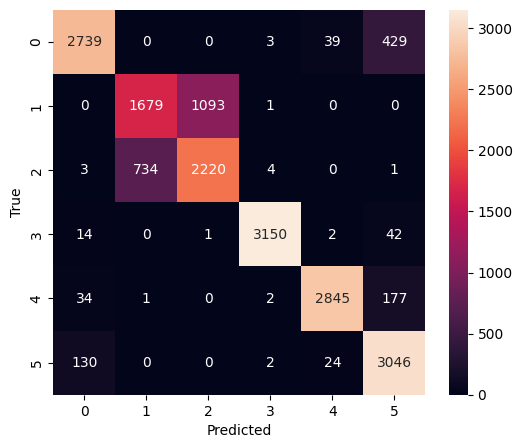

In [108]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [109]:
history

{'epoch': [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,

In [110]:
df = pd.DataFrame(history)

In [111]:
df.to_csv("../metrics/torch1/1dcnn.csv", index=False)

In [114]:
torch.save(model.state_dict(), "../artifacts/torch/onedcnn_model_cuda.pth")

In [115]:
class CNN_LSTM(nn.Module):
    def __init__(self, input_len, num_classes):
        super(CNN_LSTM, self).__init__()
        
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
    
        self.lstm = nn.LSTM(input_size=128, hidden_size=64, batch_first=True)
        
        self.fc1 = nn.Linear(64, 128)
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Input x: (batch, seq_len, 1)
        x = x.permute(0, 2, 1)                   # → (batch, 1, seq_len)
        x = torch.relu(self.bn1(self.conv1(x)))  # (batch, 64, L-2)
        x = torch.relu(self.conv2(x))            # (batch, 128, L-4)
        x = self.pool(x)                         # (batch, 128, (L-4)//2)
        
        # LSTM expects (batch, seq_len, features)
        x = x.permute(0, 2, 1)
        _, (h_n, _) = self.lstm(x)
        x = h_n[-1]                              # take last hidden state (batch, 64)
        
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x 

In [116]:
input_len = X_train_scaled.shape[1]
model = CNN_LSTM(input_len, num_classes).to(device)
print(model)

CNN_LSTM(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(128, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)


In [117]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

In [118]:
history = {
    "epoch": [],
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
    "precision": [],
    "recall": [],
    "f1": []
}

In [120]:
num_epochs = 300

for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, total = 0.0, 0, 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        total += y_batch.size(0)
        train_correct += (preds == y_batch).sum().item()
    
    avg_train_loss = train_loss / total
    train_acc = train_correct / total

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    all_preds, all_labels = [], []   # <-- NEW

    with torch.no_grad():
        for X_val, y_val in test_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            
            # collect validation loss
            loss = criterion(outputs, y_val)
            val_loss += loss.item() * X_val.size(0)

            _, preds = torch.max(outputs, 1)
            val_total += y_val.size(0)
            val_correct += (preds == y_val).sum().item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_val.cpu().numpy())

    avg_val_loss = val_loss / val_total
    val_acc = val_correct / val_total

    # Compute metrics
    precision = precision_score(all_labels, all_preds, average="macro")
    recall = recall_score(all_labels, all_preds, average="macro")
    f1 = f1_score(all_labels, all_preds, average="macro")

    # Store
    history["epoch"].append(epoch + 1)
    history["train_loss"].append(avg_train_loss)     # <-- (fix) store avg, not sum
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["val_loss"].append(avg_val_loss)         # <-- NEW
    history["precision"].append(precision)           # <-- NEW
    history["recall"].append(recall)                 # <-- NEW
    history["f1"].append(f1)                         # <-- NEW

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f} | "
          f"F1: {f1:.4f}")


Epoch [1/300] | Train Loss: 0.3480, Train Acc: 0.8326 | Val Loss: 0.3441, Val Acc: 0.8363 | F1: 0.8315
Epoch [2/300] | Train Loss: 0.3456, Train Acc: 0.8339 | Val Loss: 0.3515, Val Acc: 0.8337 | F1: 0.8289
Epoch [3/300] | Train Loss: 0.3422, Train Acc: 0.8347 | Val Loss: 0.3523, Val Acc: 0.8301 | F1: 0.8255
Epoch [4/300] | Train Loss: 0.3382, Train Acc: 0.8365 | Val Loss: 0.3363, Val Acc: 0.8383 | F1: 0.8334
Epoch [5/300] | Train Loss: 0.3367, Train Acc: 0.8369 | Val Loss: 0.3373, Val Acc: 0.8386 | F1: 0.8337
Epoch [6/300] | Train Loss: 0.3351, Train Acc: 0.8388 | Val Loss: 0.3395, Val Acc: 0.8368 | F1: 0.8319
Epoch [7/300] | Train Loss: 0.3318, Train Acc: 0.8396 | Val Loss: 0.3371, Val Acc: 0.8351 | F1: 0.8238
Epoch [8/300] | Train Loss: 0.3285, Train Acc: 0.8419 | Val Loss: 0.3306, Val Acc: 0.8403 | F1: 0.8350
Epoch [9/300] | Train Loss: 0.3271, Train Acc: 0.8410 | Val Loss: 0.3308, Val Acc: 0.8430 | F1: 0.8379
Epoch [10/300] | Train Loss: 0.3241, Train Acc: 0.8432 | Val Loss: 0.3328

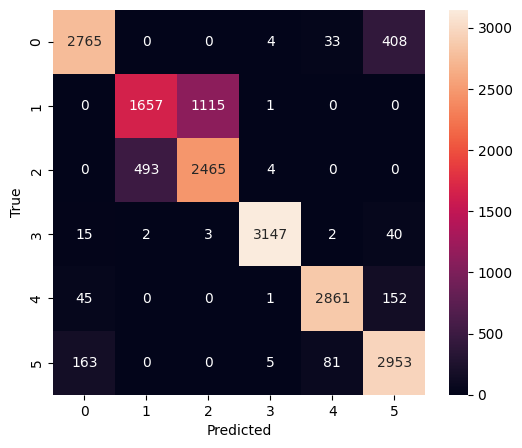

In [121]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [122]:
from sklearn.metrics import classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_val, y_val in test_loader:
        X_val, y_val = X_val.to(device), y_val.to(device)
        outputs = model(X_val)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_val.cpu().numpy())

print(classification_report(all_labels, all_preds, digits=4))

              precision    recall  f1-score   support

           0     0.9254    0.8614    0.8922      3210
           1     0.7700    0.5975    0.6729      2773
           2     0.6880    0.8322    0.7532      2962
           3     0.9953    0.9807    0.9879      3209
           4     0.9610    0.9353    0.9480      3059
           5     0.8311    0.9222    0.8743      3202

    accuracy                         0.8606     18415
   macro avg     0.8618    0.8549    0.8548     18415
weighted avg     0.8655    0.8606    0.8597     18415



In [123]:
df = pd.DataFrame(history)

In [124]:
df.to_csv("../metrics/torch/rclnet.csv", index=False)

In [125]:
torch.save(model.state_dict(), "../artifacts/torch/rclnet_cuda.pth")

In [126]:
class CNN_BiLSTM_Attention(nn.Module):
    def __init__(self, input_len, num_classes, lstm_hidden=64, num_heads=4):
        super(CNN_BiLSTM_Attention, self).__init__()
        
        # CNN feature extractor
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding='same')
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding='same')
        self.pool = nn.MaxPool1d(2)
        
        # BiLSTM block
        self.bilstm = nn.LSTM(
            input_size=128,
            hidden_size=lstm_hidden,
            batch_first=True,
            bidirectional=True
        )

        # Multi-Head Self-Attention
        self.attention = nn.MultiheadAttention(embed_dim=2*lstm_hidden, num_heads=num_heads, batch_first=True)
        self.norm = nn.LayerNorm(2*lstm_hidden)

        # Dense layers
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(2*lstm_hidden, 128)
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Input shape: (batch, seq_len, 1)
        x = x.permute(0, 2, 1)                 # (batch, 1, seq_len)
        x = torch.relu(self.conv1(x))          # (batch, 64, seq_len)
        x = torch.relu(self.conv2(x))          # (batch, 128, seq_len)
        x = self.pool(x)                       # (batch, 128, seq_len//2)
        
        # Prepare for LSTM: (batch, seq_len, features)
        x = x.permute(0, 2, 1)
        x, _ = self.bilstm(x)                  # (batch, seq_len//2, 2*lstm_hidden)
        
        # Multihead Self-Attention with residual connection
        attn_output, _ = self.attention(x, x, x)
        x = self.norm(x + attn_output)

        # Global average pooling over the sequence dimension
        x = x.permute(0, 2, 1)
        x = self.global_pool(x).squeeze(-1)    # (batch, 2*lstm_hidden)
        
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)                        # logits
        return x


In [127]:
input_len = X_train_scaled.shape[1]
model = CNN_BiLSTM_Attention(input_len, num_classes).to(device)
print(model)

CNN_BiLSTM_Attention(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=same)
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=same)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bilstm): LSTM(128, 64, batch_first=True, bidirectional=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (global_pool): AdaptiveAvgPool1d(output_size=1)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)


In [131]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

In [132]:
history = {
    "epoch": [],
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
    "precision": [],
    "recall": [],
    "f1": []
}

num_epochs = 300

for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, total = 0.0, 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        total += y_batch.size(0)
        train_correct += (preds == y_batch).sum().item()
    
    avg_train_loss = train_loss / total
    train_acc = train_correct / total

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for X_val, y_val in test_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)

            val_loss += loss.item() * X_val.size(0)
            _, preds = torch.max(outputs, 1)

            val_total += y_val.size(0)
            val_correct += (preds == y_val).sum().item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_val.cpu().numpy())

    avg_val_loss = val_loss / val_total
    val_acc = val_correct / val_total

    # Compute metrics
    precision = precision_score(all_labels, all_preds, average="macro")
    recall = recall_score(all_labels, all_preds, average="macro")
    f1 = f1_score(all_labels, all_preds, average="macro")

    # Store all of them
    history["epoch"].append(epoch + 1)
    history["train_loss"].append(avg_train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(avg_val_loss)
    history["val_acc"].append(val_acc)
    history["precision"].append(precision)
    history["recall"].append(recall)
    history["f1"].append(f1)

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f} | "
          f"F1: {f1:.4f}")

Epoch [1/300] | Train Loss: 0.2427 | Train Acc: 0.8776 | Val Loss: 0.3999 | Val Acc: 0.8519 | F1: 0.8432
Epoch [2/300] | Train Loss: 0.2430 | Train Acc: 0.8784 | Val Loss: 0.3858 | Val Acc: 0.8515 | F1: 0.8427
Epoch [3/300] | Train Loss: 0.2409 | Train Acc: 0.8781 | Val Loss: 0.3888 | Val Acc: 0.8557 | F1: 0.8483
Epoch [4/300] | Train Loss: 0.2412 | Train Acc: 0.8790 | Val Loss: 0.3926 | Val Acc: 0.8528 | F1: 0.8437
Epoch [5/300] | Train Loss: 0.2411 | Train Acc: 0.8779 | Val Loss: 0.4033 | Val Acc: 0.8509 | F1: 0.8458
Epoch [6/300] | Train Loss: 0.2412 | Train Acc: 0.8779 | Val Loss: 0.4062 | Val Acc: 0.8510 | F1: 0.8418
Epoch [7/300] | Train Loss: 0.2418 | Train Acc: 0.8780 | Val Loss: 0.3986 | Val Acc: 0.8519 | F1: 0.8431
Epoch [8/300] | Train Loss: 0.2405 | Train Acc: 0.8783 | Val Loss: 0.4206 | Val Acc: 0.8515 | F1: 0.8463
Epoch [9/300] | Train Loss: 0.2399 | Train Acc: 0.8790 | Val Loss: 0.3968 | Val Acc: 0.8507 | F1: 0.8457
Epoch [10/300] | Train Loss: 0.2405 | Train Acc: 0.8782

In [133]:
from sklearn.metrics import classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_val, y_val in test_loader:
        X_val, y_val = X_val.to(device), y_val.to(device)
        outputs = model(X_val)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_val.cpu().numpy())

print(classification_report(all_labels, all_preds, digits=4))

              precision    recall  f1-score   support

           0     0.9207    0.8611    0.8899      3210
           1     0.6655    0.6837    0.6745      2773
           2     0.6954    0.6766    0.6858      2962
           3     0.9962    0.9822    0.9892      3209
           4     0.9653    0.9278    0.9462      3059
           5     0.8304    0.9279    0.8764      3202

    accuracy                         0.8485     18415
   macro avg     0.8456    0.8432    0.8437     18415
weighted avg     0.8509    0.8485    0.8489     18415



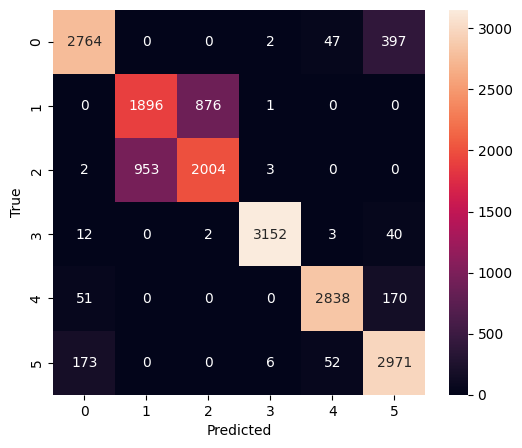

In [134]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [135]:
df = pd.DataFrame(history)
df.to_csv("../metrics/torch/rclnet-attn.csv", index=False)
torch.save(model.state_dict(), "../artifacts/torch/rclnet-attn_cuda.pth")

In [136]:
import torch.nn.functional as F

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


# -------------------------------
# Positional Encoding (optional)
# -------------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :]


# -------------------------------
# Residual Block for 1D conv
# -------------------------------
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding="same")
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding="same")
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.shortcut = (
            nn.Conv1d(in_channels, out_channels, kernel_size=1)
            if in_channels != out_channels else nn.Identity()
        )

    def forward(self, x):
        residual = self.shortcut(x)
        out = F.leaky_relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        out = F.leaky_relu(out)
        return out


# -------------------------------
# RCLNet_Attn_Pro (Tabular-ready)
# -------------------------------
class RCLNet_Attn_Pro(nn.Module):
    def __init__(self, input_features, num_classes):
        super(RCLNet_Attn_Pro, self).__init__()

        # Treat features as "sequence length = 1" if needed
        self.expand_dim = nn.Linear(input_features, input_features)
        self.res1 = ResidualBlock(1, 64)
        self.res2 = ResidualBlock(64, 128)
        self.pool = nn.AdaptiveMaxPool1d(32)

        # BiLSTM + Attention
        self.lstm = nn.LSTM(input_size=128, hidden_size=64, batch_first=True, bidirectional=True)
        self.attn = nn.MultiheadAttention(embed_dim=128, num_heads=4, dropout=0.2, batch_first=True)
        self.norm = nn.LayerNorm(128)

        # Dense classifier
        self.fc1 = nn.Linear(128, 256)
        self.drop = nn.Dropout(0.4)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # x: (B, F)
        x = self.expand_dim(x).unsqueeze(1)  # (B, 1, F)

        x = self.res1(x)
        x = self.res2(x)
        x = self.pool(x)  # (B, 128, seq_len=32)
        x = x.permute(0, 2, 1)  # (B, seq_len, F)

        # BiLSTM + Attention
        x, _ = self.lstm(x)
        attn_out, _ = self.attn(x, x, x)
        x = self.norm(x + attn_out)

        # Global average pooling
        x = x.mean(dim=1)

        # Dense classifier
        x = F.leaky_relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        return x

In [138]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
if X_train_t.dim() == 4:
    X_train_t = X_train_t.squeeze(-1)
elif X_train_t.dim() == 2:
    X_train_t = X_train_t.unsqueeze(-1)

y_train_t = torch.tensor(y_train_enc, dtype=torch.long)

X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
if X_test_t.dim() == 4:
    X_test_t = X_test_t.squeeze(-1)
elif X_test_t.dim() == 2:
    X_test_t = X_test_t.unsqueeze(-1)

y_test_t = torch.tensor(y_test_enc, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=64, shuffle=False)

In [139]:
input_features = 1              # last dim from (seq_len, features)
seq_len = X_train_scaled.shape[1]
num_classes = len(le.classes_)

In [140]:
model = RCLNet_Attn_Pro(input_features, num_classes, max_len=seq_len).to(device)
print(sum(p.numel() for p in model.parameters()) / 1e6, "M parameters")

0.296006 M parameters


In [141]:
dummy = torch.randn(8, seq_len, input_features).to(device)
out = model(dummy)
print(out.shape)

torch.Size([8, 6])


In [142]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [143]:
seq_len = X_train_scaled.shape[1]
num_classes = len(le.classes_)

In [144]:
model = RCLNet_Attn_Pro(input_features=1, num_classes=num_classes, max_len=seq_len).to(device)

In [147]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=2e-3)

In [148]:
history = {
    "epoch": [],
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
    "precision": [],
    "recall": [],
    "f1": []
}

In [150]:
EPOCHS = 300
for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    # --- Validation ---
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    all_preds, all_labels = [], []     # NEW

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)

            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    val_loss /= val_total
    val_acc = val_correct / val_total

    # Extra Metrics
    precision = precision_score(all_labels, all_preds, average="macro")
    recall = recall_score(all_labels, all_preds, average="macro")
    f1 = f1_score(all_labels, all_preds, average="macro")

    # Store metrics
    history["epoch"].append(epoch+1)
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["precision"].append(precision)
    history["recall"].append(recall)
    history["f1"].append(f1)

    print(f"Epoch [{epoch+1}/{EPOCHS}] | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} | "
          f"F1: {f1:.4f}")

Epoch [1/300] | Train Loss: 0.4102, Train Acc: 0.7910 | Val Loss: 0.3954, Val Acc: 0.7978 | F1: 0.7720
Epoch [2/300] | Train Loss: 0.3825, Train Acc: 0.8105 | Val Loss: 0.3610, Val Acc: 0.8162 | F1: 0.8088
Epoch [3/300] | Train Loss: 0.3693, Train Acc: 0.8224 | Val Loss: 0.3688, Val Acc: 0.8292 | F1: 0.8244
Epoch [4/300] | Train Loss: 0.3578, Train Acc: 0.8269 | Val Loss: 0.3527, Val Acc: 0.8211 | F1: 0.8136
Epoch [5/300] | Train Loss: 0.3492, Train Acc: 0.8311 | Val Loss: 0.3638, Val Acc: 0.8272 | F1: 0.8112
Epoch [6/300] | Train Loss: 0.3430, Train Acc: 0.8346 | Val Loss: 0.3367, Val Acc: 0.8302 | F1: 0.8217
Epoch [7/300] | Train Loss: 0.3368, Train Acc: 0.8370 | Val Loss: 0.3330, Val Acc: 0.8422 | F1: 0.8373
Epoch [8/300] | Train Loss: 0.3311, Train Acc: 0.8406 | Val Loss: 0.3318, Val Acc: 0.8390 | F1: 0.8269
Epoch [9/300] | Train Loss: 0.3293, Train Acc: 0.8414 | Val Loss: 0.3343, Val Acc: 0.8382 | F1: 0.8258
Epoch [10/300] | Train Loss: 0.3249, Train Acc: 0.8430 | Val Loss: 0.3340

In [ ]:
from sklearn.metrics import classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_val, y_val in test_loader:
        X_val, y_val = X_val.to(device), y_val.to(device)
        outputs = model(X_val)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_val.cpu().numpy())

print(classification_report(all_labels, all_preds, digits=4))

              precision    recall  f1-score   support

           0     0.9381    0.8993    0.9183      6000
           1     0.7903    0.5073    0.6179      4948
           2     0.6582    0.8752    0.7513      5359
           3     0.9906    0.9888    0.9897      6000
           4     0.9841    0.9288    0.9556      5589
           5     0.8687    0.9524    0.9086      5993

    accuracy                         0.8684     33889
   macro avg     0.8717    0.8586    0.8569     33889
weighted avg     0.8769    0.8684    0.8651     33889



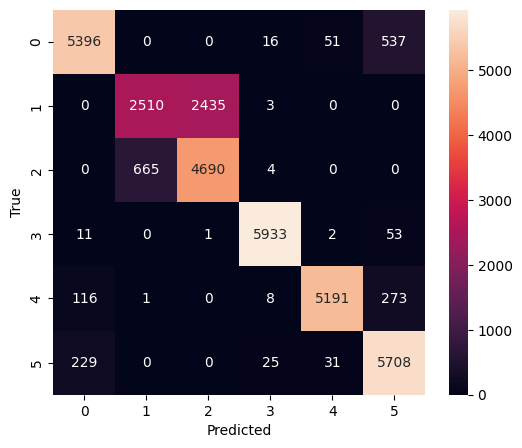

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
df = pd.DataFrame(history)
df.to_csv("../metrics/torch/rclnet-multiheadselfattn.csv", index=False)
torch.save(model.state_dict(), "../artifacts/torch/rclnet-MULTI_cuda.pth")